In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as sm
from sklearn.metrics import mean_absolute_percentage_error
from IPython.core.pylabtools import figsize

%matplotlib inline

In [2]:
SIZE_X = 14
SIZE_Y = 7
figsize(SIZE_X, SIZE_Y)

In [3]:
df = pd.read_csv('data/raw/Amazon_Historical_StockPrice2.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,584.400024,584.750000,575.559998,579.869995,579.869995,3121500
1,2016-03-29,580.150024,595.849976,576.500000,593.859985,593.859985,4392600
2,2016-03-30,596.710022,603.239990,595.000000,598.690002,598.690002,3890500
3,2016-03-31,599.280029,600.750000,592.210022,593.640015,593.640015,2681800
4,2016-04-01,590.489990,599.030029,588.299988,598.500000,598.500000,2917400


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1260 non-null   object 
 1   Open       1260 non-null   float64
 2   High       1260 non-null   float64
 3   Low        1260 non-null   float64
 4   Close      1260 non-null   float64
 5   Adj Close  1260 non-null   float64
 6   Volume     1260 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [5]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
df.Date = pd.to_datetime(df.Date, yearfirst=True)
df.set_index(['Date'], inplace=True)

In [7]:
df.sort_index(inplace=True)

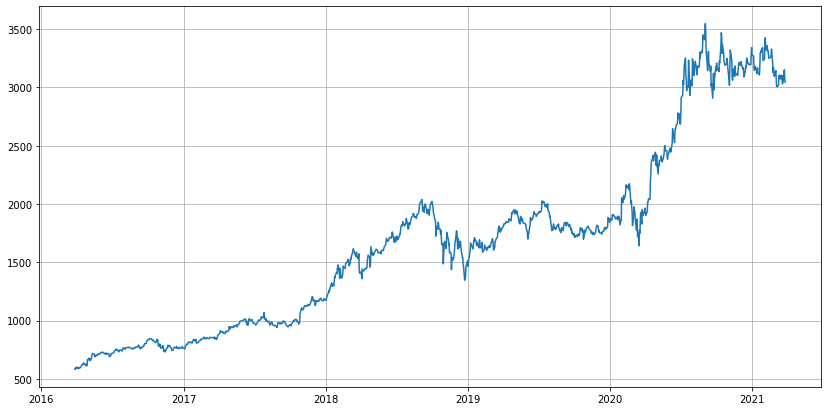

In [8]:
plt.plot(df.Open)
plt.grid()
plt.show()

<AxesSubplot:xlabel='Date'>

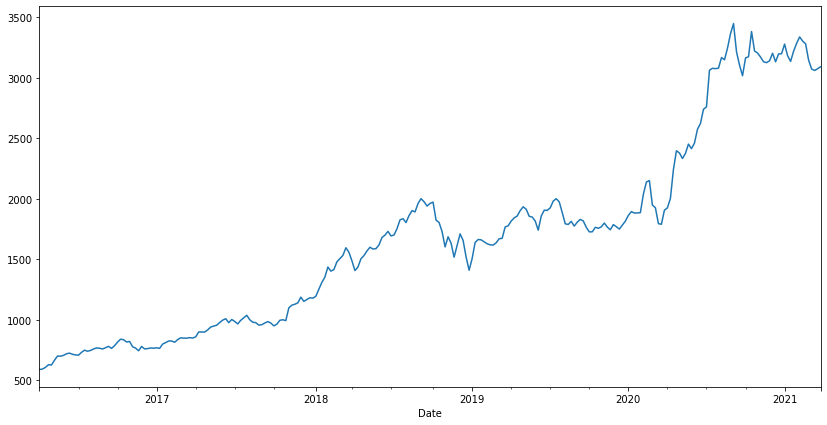

In [9]:
df = df.resample('W').mean()
df.Open.plot()

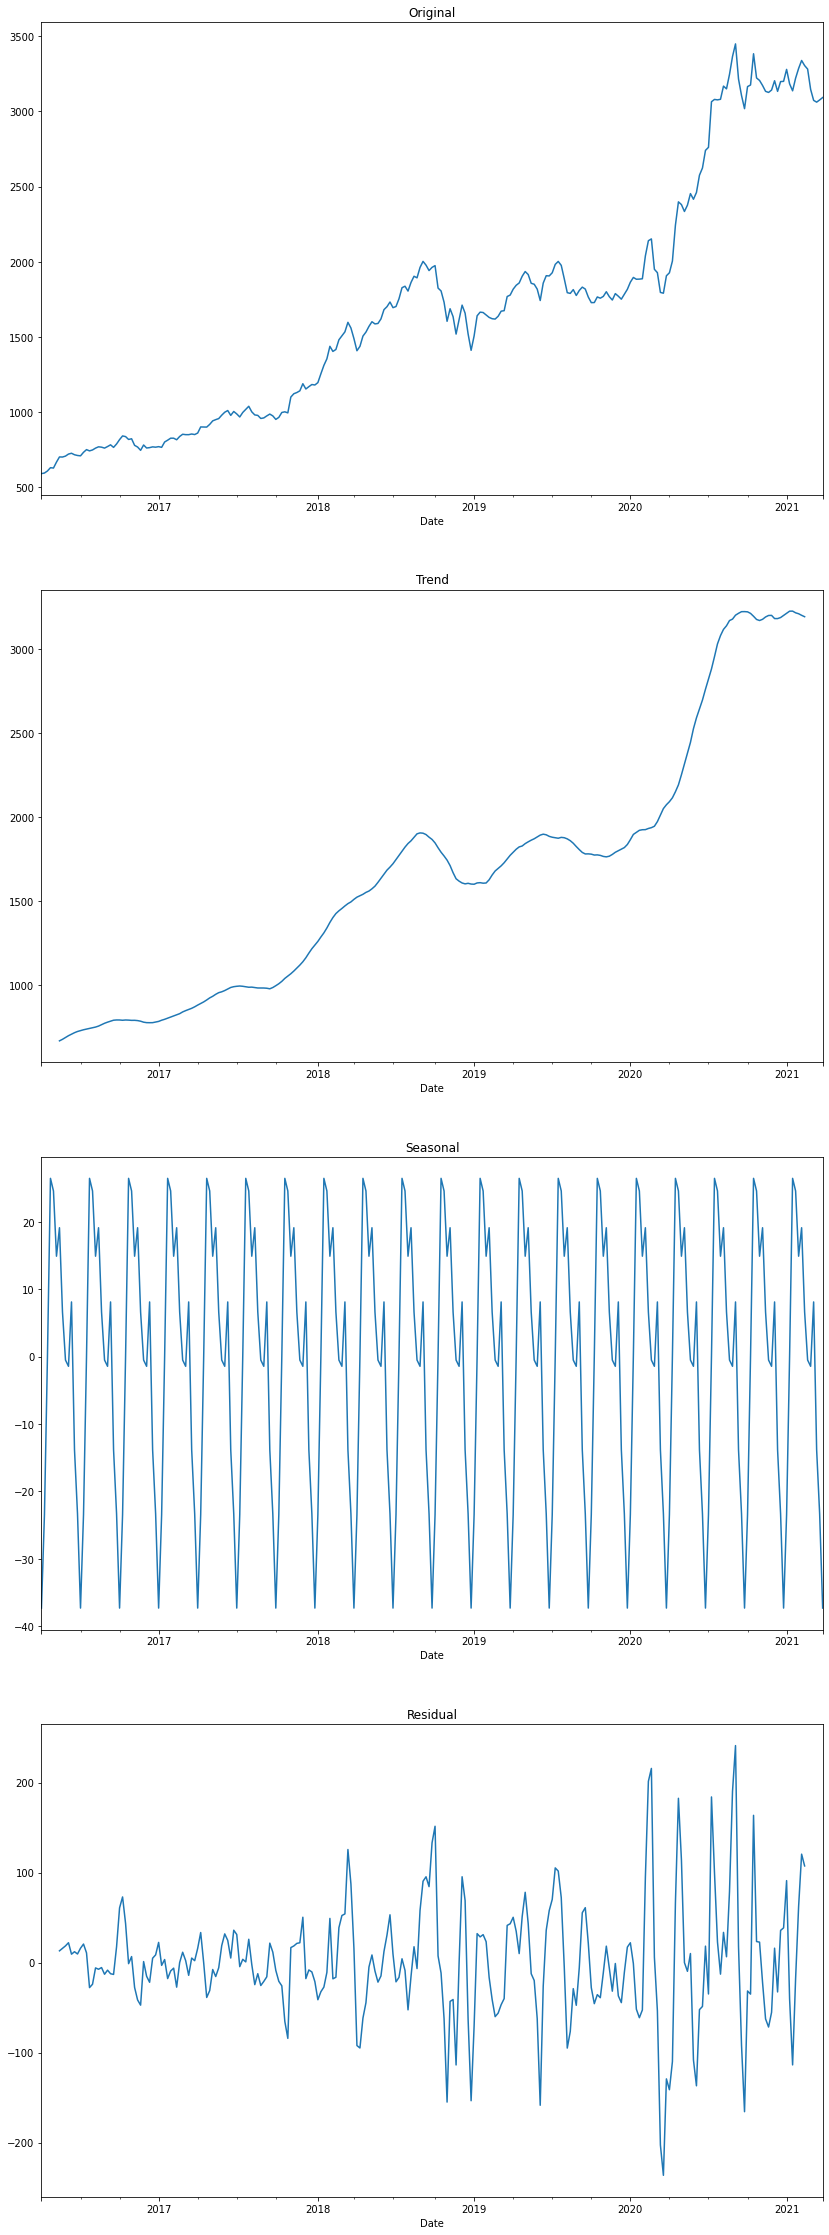

In [10]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(df.Open, period=13)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

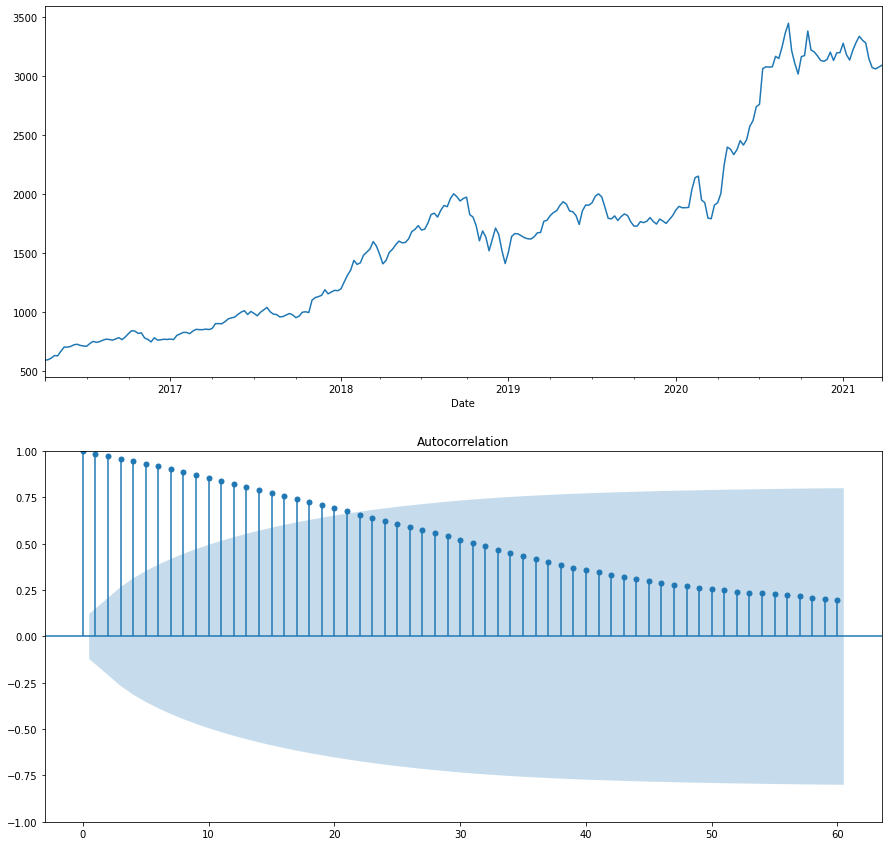

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
df.Open.plot(ax=ax[0])
plot_acf(df.Open, lags=60, ax=ax[1]);

<AxesSubplot:xlabel='Date'>

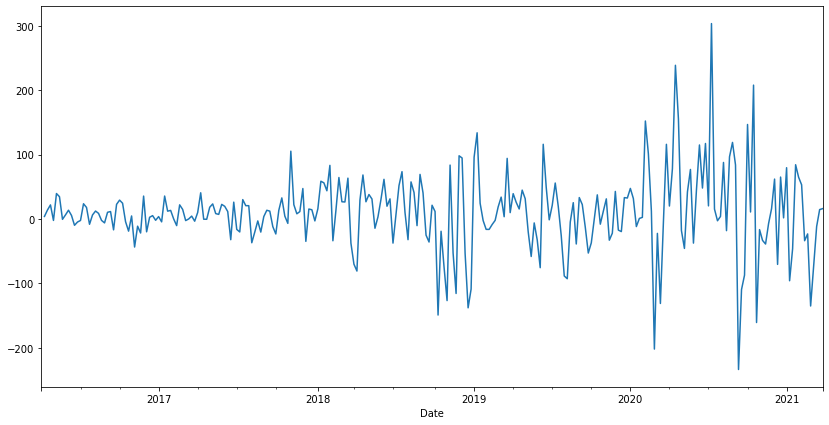

In [12]:
df['Open_diff'] = df.Open.diff()
df.Open_diff.plot()

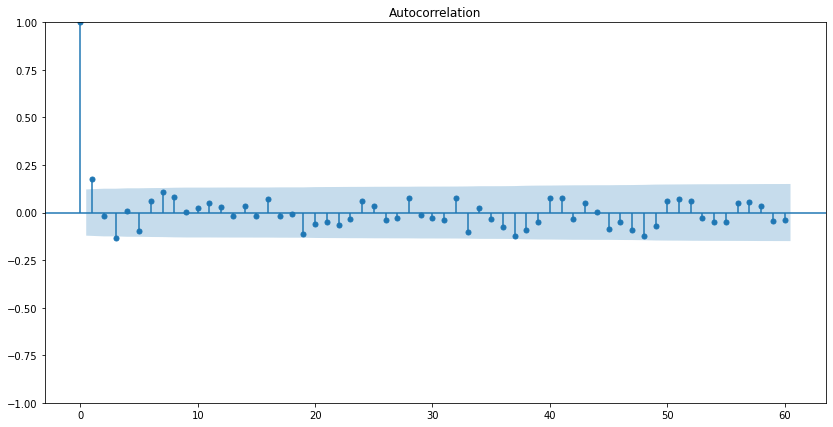

In [13]:
plot_acf(df.Open_diff[1:], lags=60)
plt.show()

<AxesSubplot:xlabel='Date'>

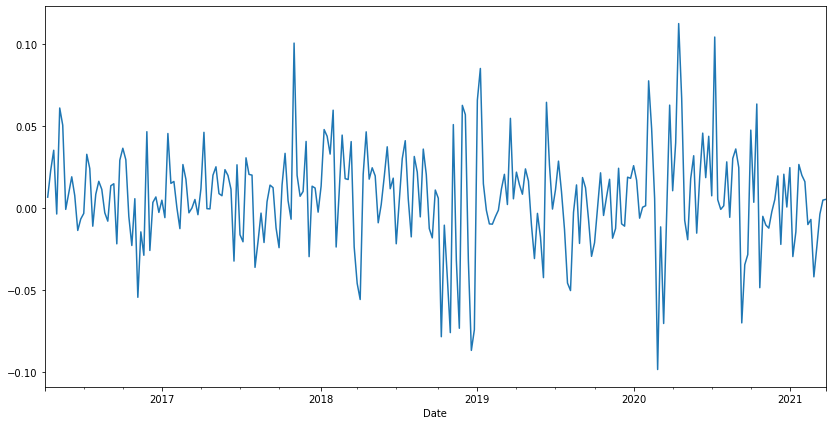

In [14]:
df['Open_log'] = np.log(df.Open)
df['Open_log_diff'] = df.Open_log.diff()
df.Open_log_diff.plot()

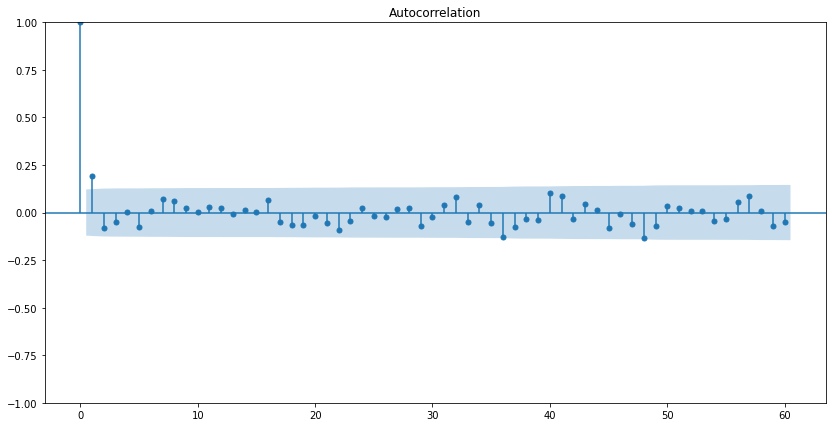

In [15]:
plot_acf(df.Open_log_diff[1:], lags=60)
plt.show()

In [16]:
p_value = adfuller(df['Open_log_diff'][1:])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Ряд станционарен'
)

Полученный уровень значимости (p-value): 0.0. 0.0 < 0.05. Ряд станционарен


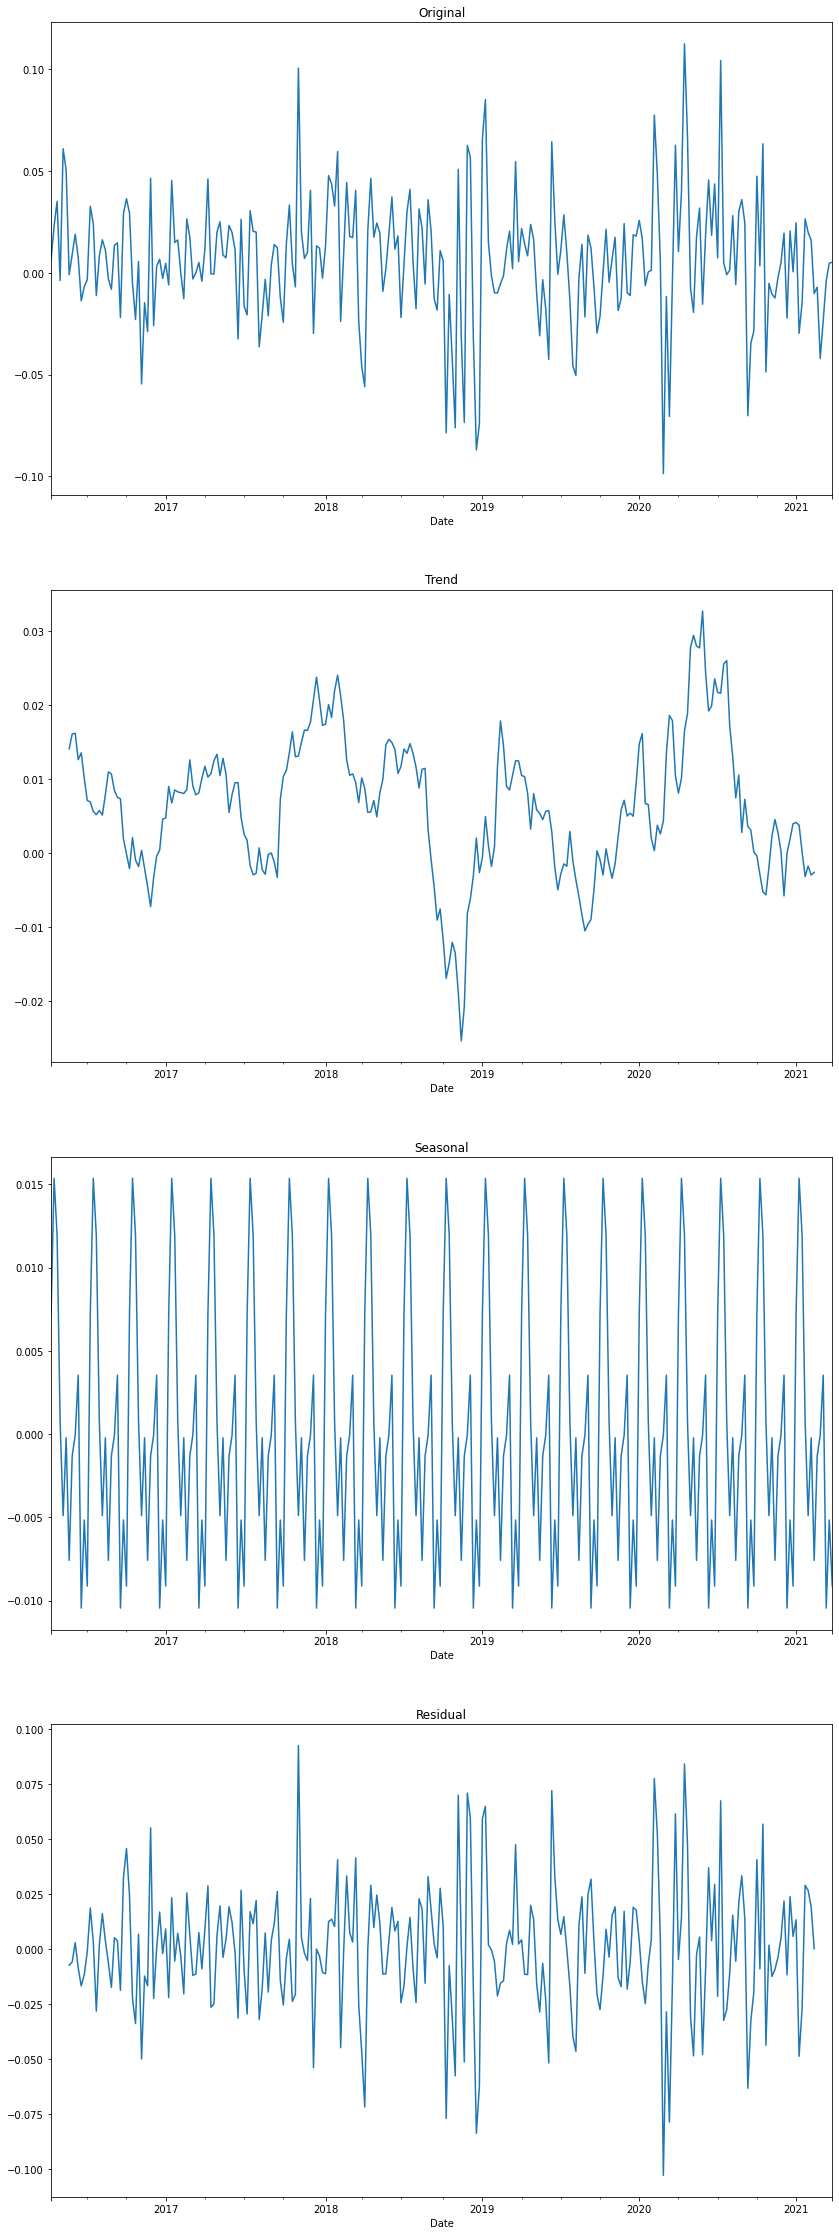

In [17]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(df.Open_log_diff[1:], period=13)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

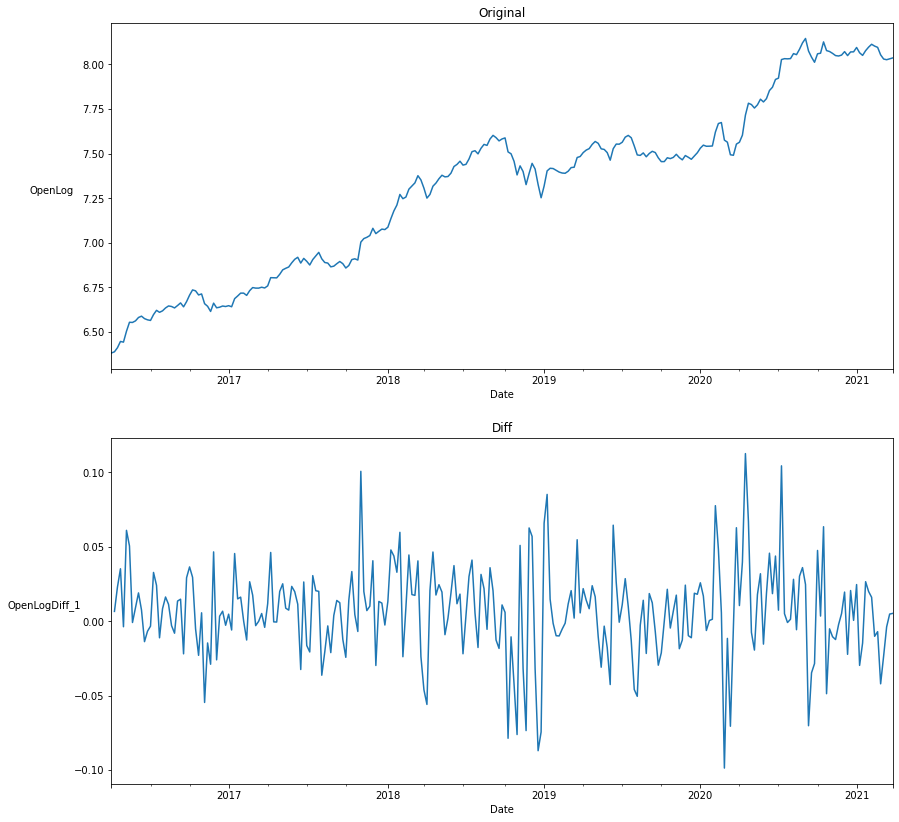

In [18]:
plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

ax = plt.subplot(211)
ax.set_title('Original')
ax.set_ylabel('OpenLog', rotation=0, labelpad=30)
df['Open_log'].plot(ax=ax);

ax = plt.subplot(212)
ax.set_title('Diff')
ax.set_ylabel('OpenLogDiff_1', rotation=0, labelpad=30)
df['Open_log_diff'].plot(ax=ax);

<AxesSubplot:xlabel='Open_log_diff', ylabel='Count'>

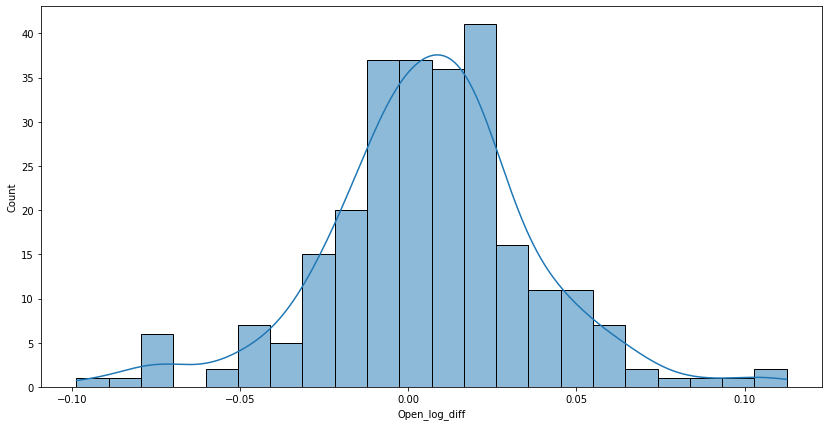

In [19]:
sns.histplot(data=df[1:], x='Open_log_diff', kde=True)

In [20]:
ds = range(0, 3)
D = 1

qs = range(1, 3)
Qs = range(1, 3)
ps = range(1, 3)
Ps = range(3, 5)

In [22]:
from tqdm import tqdm
from itertools import product
import warnings
warnings.filterwarnings('ignore')

params = product(ps, ds, qs, Ps, Qs)
results = []
best_aic = float("inf")

for (p, d, q, P, Q) in tqdm(list(params)):
    model = sm.SARIMAX(df.Open_log.head(int(len(df) * 0.8)),
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, 13)).fit(disp=-1)
    if model.aic < best_aic:
        best_model = model
        best_aic = model.aic
        best_param = (p, q, d, P, Q)
    results.append([(p, q, d, P, Q), model.aic])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [06:05<00:00,  7.60s/it]


In [23]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

         parameters         aic
10  (1, 1, 1, 4, 1) -769.811751
0   (1, 1, 0, 3, 1) -769.221668
9   (1, 1, 1, 3, 2) -768.952570
14  (1, 2, 1, 4, 1) -768.736644
33  (2, 1, 1, 3, 2) -767.831754


In [24]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Open_log   No. Observations:                  208
Model:             SARIMAX(1, 1, 1)x(4, 1, 1, 13)   Log Likelihood                 392.906
Date:                            Sun, 20 Feb 2022   AIC                           -769.812
Time:                                    15:43:07   BIC                           -743.669
Sample:                                04-03-2016   HQIC                          -759.226
                                     - 03-22-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1067      0.241     -0.443      0.658      -0.579       0.365
ma.L1          0.3442      0.234      1.471      0.141      -0.115       0.803
ar.S.L13      -0.0242      0.136     -0.178      0.859      -0.291       0.243
ar.S.L26      -0.0470      0.103     -0.459      0.647      -0.248       0.154
ar.S.L39      -0.1068      0.092     -1.165      0.244      -0.286       0.073
ar.S.L52      -0.1011      0.090     -1.126      0.260      -0.277       0.075
ma.S.L13      -0.9077      0.241     -3.774      0.000      -1.379      -0.436
sigma2         0.0009      0.000      6.403      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                27.53
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                            -0.36
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
df['Model'] = np.exp(best_model.predict(start=int(len(df) * 0.8)-1, end = len(df)))

<AxesSubplot:xlabel='Date'>

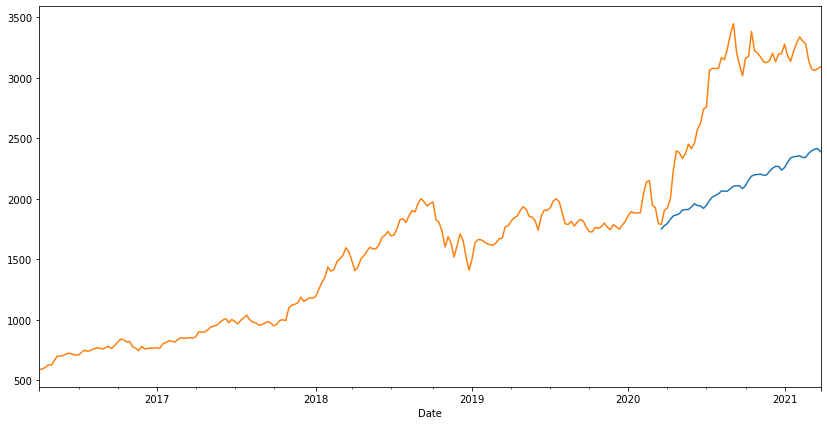

In [26]:
df.Model.plot()
df.Open.plot()

In [27]:
mean_absolute_percentage_error(df.Open[int(len(df) * 0.8):],
                               df.Model[int(len(df) * 0.8):])

0.2731322323399823